In [60]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.utils import shuffle
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import precision_score, recall_score, f1_score

## Data Exploration & Preprocessing

In [3]:
df = pd.read_csv('Alphabets_data.csv')

In [4]:
df.shape

(20000, 17)

In [5]:
df.columns.tolist()

['letter',
 'xbox',
 'ybox',
 'width',
 'height',
 'onpix',
 'xbar',
 'ybar',
 'x2bar',
 'y2bar',
 'xybar',
 'x2ybar',
 'xy2bar',
 'xedge',
 'xedgey',
 'yedge',
 'yedgex']

In [6]:
df.head()

,letter,xbox,ybox,width,height,onpix,xbar,ybar,x2bar,y2bar,xybar,x2ybar,xy2bar,xedge,xedgey,yedge,yedgex
0,T,2,8,3,5,1,8,13,0,6,6,10,8,0,8,0,8
1,I,5,12,3,7,2,10,5,5,4,13,3,9,2,8,4,10
2,D,4,11,6,8,6,10,6,2,6,10,3,7,3,7,3,9
3,N,7,11,6,6,3,5,9,4,6,4,4,10,6,10,2,8
4,G,2,1,3,1,1,8,6,6,6,6,5,9,1,7,5,10


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 17 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   letter  20000 non-null  object
 1   xbox    20000 non-null  int64 
 2   ybox    20000 non-null  int64 
 3   width   20000 non-null  int64 
 4   height  20000 non-null  int64 
 5   onpix   20000 non-null  int64 
 6   xbar    20000 non-null  int64 
 7   ybar    20000 non-null  int64 
 8   x2bar   20000 non-null  int64 
 9   y2bar   20000 non-null  int64 
 10  xybar   20000 non-null  int64 
 11  x2ybar  20000 non-null  int64 
 12  xy2bar  20000 non-null  int64 
 13  xedge   20000 non-null  int64 
 14  xedgey  20000 non-null  int64 
 15  yedge   20000 non-null  int64 
 16  yedgex  20000 non-null  int64 
dtypes: int64(16), object(1)
memory usage: 2.6+ MB


In [8]:
df.isnull().sum()

letter    0
xbox      0
ybox      0
width     0
height    0
onpix     0
xbar      0
ybar      0
x2bar     0
y2bar     0
xybar     0
x2ybar    0
xy2bar    0
xedge     0
xedgey    0
yedge     0
yedgex    0
dtype: int64

In [9]:
possible_label_names = {"label", "class", "target", "y"}
label_col = None

In [10]:
for name in df.columns:
    if name.lower() in possible_label_names:
        label_col = name
        break

In [11]:
if label_col is None:
    n = len(df)
    candidates = []
    for c in df.columns:
        nunique = df[c].nunique(dropna=False)
        if nunique <= max(52, int(0.05*n)):
            candidates.append((c, nunique, df[c].dtype))
            if candidates:
                candidates.sort(key=lambda x: (str(x[2]).startswith('float') or str(x[2]).startswith('int'), x[1]))
                label_col = candidates[0][0]
            else:
                label_col = df.columns[-1]

print(f"\nChosen label column: {label_col}")


Chosen label column: letter


In [12]:
if df[label_col].dtype == object:
    y_raw = df[label_col].astype(str)
else:
    y_raw = df[label_col]

In [13]:
X_raw = df.drop(columns=[label_col])

In [14]:
for col in X_raw.columns:
    if not np.issubdtype(X_raw[col].dtype, np.number):
        X_raw[col] = X_raw[col].astype('category').cat.codes

In [15]:
imputer = SimpleImputer(strategy='median')
X_imputed = imputer.fit_transform(X_raw)
X_imputed = pd.DataFrame(X_imputed, columns=X_raw.columns)

In [16]:
if not np.issubdtype(y_raw.dtype, np.number):
    y_encoded = y_raw.astype('category').cat.codes.values
    class_mapping = dict(enumerate(y_raw.astype('category').cat.categories))
else:
    y_encoded = y_raw.values
    class_mapping = {int(v): int(v) for v in np.unique(y_encoded)}

In [17]:
num_classes = len(np.unique(y_encoded))
print(f"\nSamples: {len(df)}, Features: {X_imputed.shape[1]}, Classes: {num_classes}")
print("Class mapping (id -> label):", class_mapping)


Samples: 20000, Features: 16, Classes: 26
Class mapping (id -> label): {0: 'A', 1: 'B', 2: 'C', 3: 'D', 4: 'E', 5: 'F', 6: 'G', 7: 'H', 8: 'I', 9: 'J', 10: 'K', 11: 'L', 12: 'M', 13: 'N', 14: 'O', 15: 'P', 16: 'Q', 17: 'R', 18: 'S', 19: 'T', 20: 'U', 21: 'V', 22: 'W', 23: 'X', 24: 'Y', 25: 'Z'}


In [18]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

In [19]:
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_encoded, stratify=y_encoded)

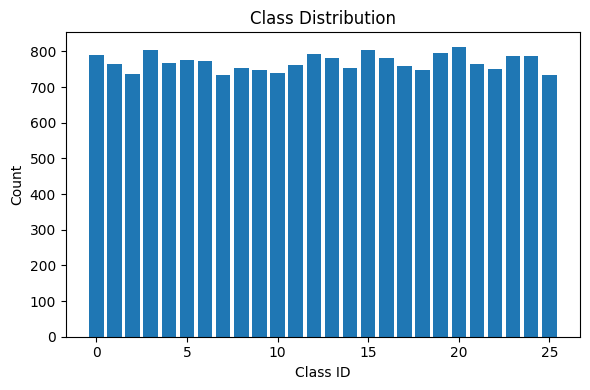

In [20]:
plt.figure(figsize=(6,4))
unique, counts = np.unique(y_encoded, return_counts=True)
plt.bar(unique, counts)
plt.title("Class Distribution")
plt.xlabel("Class ID")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

## Baseline ANN Model

In [21]:
def build_baseline_model(input_dim, num_classes):
    model = keras.Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.2),
        layers.Dense(num_classes, activation='softmax') if num_classes > 2 else layers.Dense(1, activation='sigmoid')
    ])
    lr = 1e-3
    opt = keras.optimizers.Adam(learning_rate=lr)
    loss = 'sparse_categorical_crossentropy' if num_classes > 2 else 'binary_crossentropy'
    model.compile(optimizer=opt, loss=loss, metrics=['accuracy'])
    return model

In [22]:
input_dim = X_train.shape[1]

In [23]:
baseline_model = build_baseline_model(input_dim, num_classes)
callbacks = [
keras.callbacks.EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True),
keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4)
]


history_baseline = baseline_model.fit(
X_train, y_train,
epochs=50,
batch_size=64,
callbacks=callbacks,
verbose=0
)

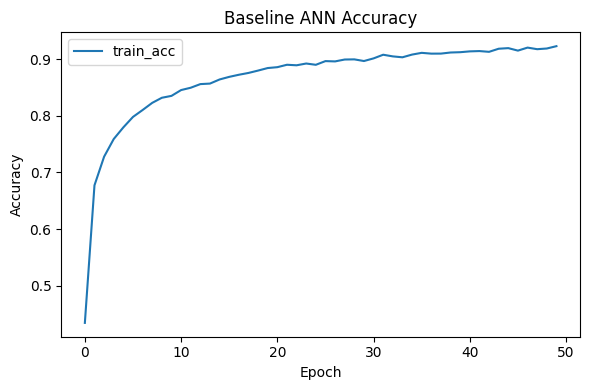

In [24]:
plt.figure(figsize=(6,4))
plt.plot(history_baseline.history['accuracy'], label='train_acc')

val_key = 'val_accuracy' if 'val_accuracy' in history_baseline.history else 'val_acc'

if val_key in history_baseline.history:
    plt.plot(history_baseline.history[val_key], label='val_acc')

plt.title('Baseline ANN Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()


In [25]:
baseline_preds_proba = baseline_model.predict(X_test, verbose=0)
if num_classes > 2:
    baseline_preds = np.argmax(baseline_preds_proba, axis=1)
else:
    baseline_preds = (baseline_preds_proba.ravel() >= 0.5).astype(int)

In [26]:
baseline_acc = accuracy_score(y_test, baseline_preds)
prec, rec, f1, _ = precision_recall_fscore_support(y_test, baseline_preds, average='macro', zero_division=0)
print("\n=== Baseline Performance ===")
print(f"Accuracy: {baseline_acc:.4f}\nPrecision (macro): {prec:.4f}\nRecall (macro): {rec:.4f}\nF1 (macro): {f1:.4f}")
print("\nClassification Report (Baseline):\n", classification_report(y_test, baseline_preds, zero_division=0))


=== Baseline Performance ===
Accuracy: 0.9418
Precision (macro): 0.9423
Recall (macro): 0.9415
F1 (macro): 0.9416

Classification Report (Baseline):
               precision    recall  f1-score   support

           0       0.98      0.98      0.98       197
           1       0.87      0.97      0.92       191
           2       0.97      0.95      0.96       184
           3       0.92      0.90      0.91       201
           4       0.88      0.93      0.91       192
           5       0.93      0.94      0.94       194
           6       0.96      0.92      0.94       193
           7       0.88      0.85      0.86       183
           8       0.97      0.93      0.95       189
           9       0.96      0.94      0.95       187
          10       0.92      0.95      0.93       185
          11       0.97      0.94      0.95       190
          12       0.96      0.94      0.95       198
          13       0.94      0.93      0.94       196
          14       0.91      0.92     

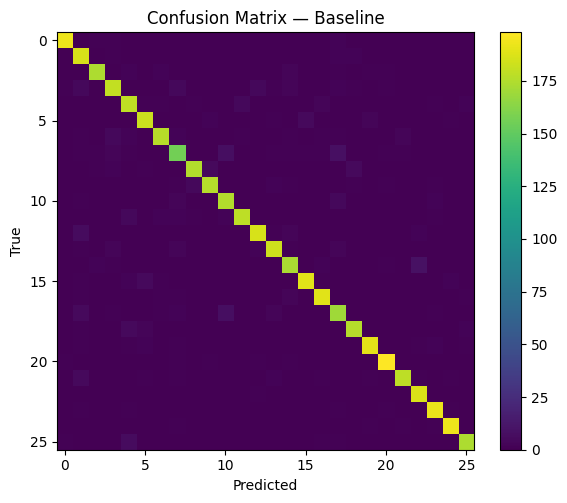

In [27]:
cm = confusion_matrix(y_test, baseline_preds)
plt.figure(figsize=(6,5))
plt.imshow(cm, interpolation='nearest')
plt.title('Confusion Matrix — Baseline')
plt.colorbar()
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.show()

## Hyperparameter Tuning

In [31]:
X = df.drop("letter", axis=1).values
y = df["letter"].values

In [32]:
num_classes = len(np.unique(y))

In [33]:
TEST_SIZE = 0.2
VAL_SIZE_WITHIN_TRAIN = 0.2
RANDOM_STATE = 42

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y
)

X_tr, X_val, y_tr, y_val = train_test_split(
    X_train, y_train, test_size=VAL_SIZE_WITHIN_TRAIN, random_state=RANDOM_STATE, stratify=y_train
)


In [34]:
scaler = StandardScaler()
X_tr = scaler.fit_transform(X_tr)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

In [37]:
def build_model(cfg, input_dim, num_classes):
    model = keras.models.Sequential()
    model.add(layers.Dense(cfg['units'], activation=cfg['activation'], input_shape=(input_dim,)))
    for _ in range(cfg['hidden_layers'] - 1):
        model.add(layers.Dense(cfg['units'], activation=cfg['activation']))
    model.add(layers.Dropout(0.3))
    if num_classes > 2:
        model.add(layers.Dense(num_classes, activation='softmax'))
        loss = 'sparse_categorical_crossentropy'
    else:
        model.add(layers.Dense(1, activation='sigmoid'))
        loss = 'binary_crossentropy'
    opt = keras.optimizers.Adam(learning_rate=cfg['learning_rate'])
    model.compile(optimizer=opt, loss=loss, metrics=['accuracy'])
    return model

In [43]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_tr = le.fit_transform(y_tr)   
y_val = le.transform(y_val)
y_test = le.transform(y_test)   

In [44]:
print(y_tr[:10])
print(type(y_tr[0]))

[11  6 19 18 23 22 24 14 18 14]
<class 'numpy.int64'>


In [45]:
history_baseline = baseline_model.fit(
    X_tr, y_tr,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=32,
    verbose=1
)

Epoch 1/20
400/400 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.2081 - loss: 2.7983 - val_accuracy: 0.6450 - val_loss: 1.5372
Epoch 2/20
400/400 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5864 - loss: 1.4830 - val_accuracy: 0.7169 - val_loss: 1.1036
Epoch 3/20
400/400 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6474 - loss: 1.1807 - val_accuracy: 0.7466 - val_loss: 0.9412
Epoch 4/20
400/400 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6899 - loss: 1.0339 - val_accuracy: 0.7650 - val_loss: 0.8514
Epoch 5/20
400/400 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7075 - loss: 0.9636 - val_accuracy: 0.7797 - val_loss: 0.7874
Epoch 6/20
400/400 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7305 - loss: 0.8795 - val_accuracy: 0.7881 - val_loss: 0.7419
Epoch 7/20
400/400 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7410 - loss: 0.8495 - val_accuracy: 0.7978 - val_loss: 0.7006
Epoch 8/20
400/400 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7480 - loss: 0.8260 - val_accuracy: 0.

In [46]:
baseline_cfg = {'hidden_layers': 1, 'units': 64, 'activation': 'relu', 'learning_rate': 0.001}
baseline_model = build_model(baseline_cfg, X_tr.shape[1], num_classes)

history_baseline = baseline_model.fit(
    X_tr, y_tr,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=32,
    verbose=1
)

Epoch 1/20
400/400 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.1965 - loss: 2.8441 - val_accuracy: 0.6250 - val_loss: 1.5703
Epoch 2/20
400/400 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5639 - loss: 1.5307 - val_accuracy: 0.7094 - val_loss: 1.1347
Epoch 3/20
400/400 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6477 - loss: 1.2168 - val_accuracy: 0.7462 - val_loss: 0.9687
Epoch 4/20
400/400 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6706 - loss: 1.0797 - val_accuracy: 0.7569 - val_loss: 0.8743
Epoch 5/20
400/400 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6952 - loss: 0.9878 - val_accuracy: 0.7766 - val_loss: 0.8099
Epoch 6/20
400/400 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7223 - loss: 0.9197 - val_accuracy: 0.7912 - val_loss: 0.7580
Epoch 7/20
400/400 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7416 - loss: 0.8580 - val_accuracy: 0.7997 - val_loss: 0.7135
Epoch 8/20
400/400 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7452 - loss: 0.8265 - val_accuracy: 0.

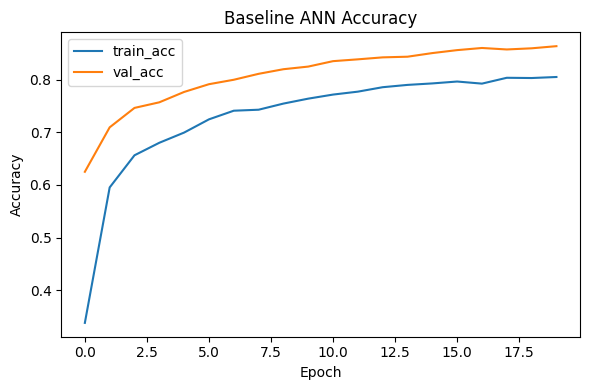

In [47]:
plt.figure(figsize=(6,4))
plt.plot(history_baseline.history['accuracy'], label='train_acc')
plt.plot(history_baseline.history['val_accuracy'], label='val_acc')
plt.title('Baseline ANN Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

In [48]:
param_grid = [
    {'hidden_layers': 1, 'units': 64,  'activation': 'relu', 'learning_rate': 0.001},
    {'hidden_layers': 2, 'units': 128, 'activation': 'relu', 'learning_rate': 0.001},
    {'hidden_layers': 2, 'units': 128, 'activation': 'tanh', 'learning_rate': 0.0005},
    {'hidden_layers': 3, 'units': 256, 'activation': 'relu', 'learning_rate': 0.0001},
]


In [49]:
best_cfg = None
best_val_acc = -np.inf
best_history = None
best_model = None

for cfg in param_grid:
    model = build_model(cfg, X_tr.shape[1], num_classes)
    history = model.fit(
        X_tr, y_tr,
        validation_data=(X_val, y_val),
        epochs=20,
        batch_size=32,
        verbose=0
    )
    val_acc = max(history.history['val_accuracy'])
    print("Tried:", cfg, "Val Acc:", val_acc)
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_cfg = cfg
        best_history = history
        best_model = model

print("\nBest Config:", best_cfg, "Best Val Acc:", best_val_acc)

Tried: {'hidden_layers': 1, 'units': 64, 'activation': 'relu', 'learning_rate': 0.001} Val Acc: 0.8634374737739563
Tried: {'hidden_layers': 2, 'units': 128, 'activation': 'relu', 'learning_rate': 0.001} Val Acc: 0.9487500190734863
Tried: {'hidden_layers': 2, 'units': 128, 'activation': 'tanh', 'learning_rate': 0.0005} Val Acc: 0.8987500071525574
Tried: {'hidden_layers': 3, 'units': 256, 'activation': 'relu', 'learning_rate': 0.0001} Val Acc: 0.918749988079071

Best Config: {'hidden_layers': 2, 'units': 128, 'activation': 'relu', 'learning_rate': 0.001} Best Val Acc: 0.9487500190734863


## Evaluation

In [50]:
y_pred = np.argmax(best_model.predict(X_test), axis=1) if num_classes > 2 else (best_model.predict(X_test) > 0.5).astype("int32").flatten()

125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 951us/step


In [61]:
print("Test Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred, average='weighted'))
print("Recall:", recall_score(y_test, y_pred, average='weighted'))
print("F1 Score:", f1_score(y_test, y_pred, average='weighted'))

Test Accuracy: 0.95175
Precision: 0.9526386896621412
Recall: 0.95175
F1 Score: 0.9518697345259407


=== Discussion Notes ===

• Data normalization (StandardScaler) improved optimization stability for ANN.

• EarlyStopping and ReduceLROnPlateau helped avoid overfitting and tuned learning rates.

• Hyperparameters (layers/units/activation/lr/batch_size/dropout) materially affect validation accuracy.

• Compare confusion matrices to see which classes benefited most from tuning.